In [1]:
# import packeges
import pandas as pd
import numpy as np
import os
from IPython.display import Image, display
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings
import lightgbm as lgb
import plotly.graph_objects as go
import plotly.express as px


from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

In [2]:
# confirm version
import causalml
print(causalml.__version__)

0.11.0


In [3]:
# load data
base_path = "/Users/ryoto/workspace/hit-u/zemi/econome_ml_demo/data/"
mail = pd.read_csv(os.path.join(base_path,'E-MailAnalytics.csv'))
print(mail.shape)
mail.head()

(64000, 12)


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [4]:
# バイアスのあるデータセットを作りたい
# segment == Men's E-mail のデータのみで実験する
male_df = mail.query("segment != 'Womens E-Mail'")
male_df["segment"] = male_df.segment.map(lambda x: 1 if x == 'Mens E-Mail' else 0)
male_df = male_df.rename(columns={"segment" : "treatment"})
print(male_df.shape)
display(male_df.head())

sample_rules = (male_df.history > 300) | (male_df.recency < 6) | (male_df.channel=='Multichannel')
mail_df = pd.concat([
    male_df[(sample_rules) & (male_df.treatment == 0)].sample(frac=0.5, random_state=1),
    male_df[(sample_rules) & (male_df.treatment == 1)],
    male_df[(~sample_rules) & (male_df.treatment == 0)],
    male_df[(~sample_rules) & (male_df.treatment == 1)].sample(frac=0.5, random_state=1)
], axis=0, ignore_index=True)

print(mail_df.shape)
display(mail_df.head())

(42613, 12)


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,visit,conversion,spend
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,0,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,1,0,0,0.0
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,1,0,0,0.0
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,1,1,0,0.0
14,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,0,0,0,0.0


(31925, 12)


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,visit,conversion,spend
0,8,5) $500 - $750,572.65,1,0,Urban,1,Web,0,0,0,0.0
1,5,1) $0 - $100,42.38,1,0,Urban,1,Phone,0,1,0,0.0
2,1,"7) $1,000 +",3003.48,1,1,Urban,1,Phone,0,0,0,0.0
3,1,5) $500 - $750,662.10,0,1,Urban,1,Web,0,0,0,0.0
4,5,1) $0 - $100,44.37,0,1,Urban,0,Web,0,0,0,0.0


In [5]:
# ラベルエンコーディング（OrdinalEncoder）
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()
encoded = oe.fit_transform(mail_df[['history_segment', 'zip_code', "channel"]].values)
# decoded = oe.inverse_transform(encoded)

print('エンコード結果: ')
encoded_df = pd.DataFrame(encoded, columns = ["history_segment", "zip_code", "channel"])
encoded_df.head()

mail_df_use = mail_df[
    ['recency', 'history', 'mens', 'womens', 'newbie', 'treatment', 'visit', 'conversion', 'spend']
    ]
demo_df = pd.concat([mail_df_use.reset_index(), encoded_df], axis = 1).drop(columns = "index")
print(demo_df.shape)
demo_df.head()

エンコード結果: 
(31925, 12)


,recency,history,mens,womens,newbie,treatment,visit,conversion,spend,history_segment,zip_code,channel
0,8,572.65,1,0,1,0,0,0,0.0,4.0,2.0,2.0
1,5,42.38,1,0,1,0,1,0,0.0,0.0,2.0,1.0
2,1,3003.48,1,1,1,0,0,0,0.0,6.0,2.0,1.0
3,1,662.10,0,1,1,0,0,0,0.0,4.0,2.0,2.0
4,5,44.37,0,1,0,0,0,0,0.0,0.0,2.0,2.0


In [6]:
# treatment 0, 1 のデータフレームに分ける
treatment_1 = male_df.query("treatment == 1")
treatment_0 = male_df.query("treatment == 0")

# 介入が購買金額に与えた影響を計算する
ts_1 = treatment_1["spend"].mean()
ts_0 = treatment_0["spend"].mean()
print("介入が購買金額に与えた影響は,", np.round(ts_1 - ts_0, 3))

# 介入がconversionに与えた影響を計算する
tc_1 = treatment_1["conversion"].mean()
tc_0 = treatment_0["conversion"].mean()
True_ATE = np.round((tc_1 - tc_0), 5)
print("介入がconversionに与えた影響は,", True_ATE)

介入が購買金額に与えた影響は, 0.77
介入がconversionに与えた影響は, 0.00681


In [7]:
# set data 
def df_sample(df, sample_size:int, random_state:int):
    df = df.sample(sample_size, random_state = random_state)
    return df

demo_df_sampled = df_sample(demo_df, sample_size=len(demo_df), random_state=42)
print(demo_df_sampled.shape)
display(demo_df_sampled.head())

print("conversion == 0", len(demo_df_sampled) - demo_df_sampled[["conversion"]].sum())
print("conversion == 1", demo_df_sampled[["conversion"]].sum())

y = demo_df_sampled.conversion
T = demo_df_sampled.treatment
X = demo_df_sampled.drop(columns=["conversion", "treatment", "spend", "visit"])

(31925, 12)


,recency,history,mens,womens,newbie,treatment,visit,conversion,spend,history_segment,zip_code,channel
18078,1,29.99,0,1,0,1,0,0,0.0,0.0,2.0,1.0
2153,5,135.10,0,1,0,0,0,0,0.0,1.0,2.0,1.0
25017,6,29.99,0,1,1,0,0,0,0.0,0.0,1.0,2.0
1668,5,29.99,1,0,0,0,1,0,0.0,0.0,2.0,2.0
15851,1,883.04,1,1,1,1,1,0,0.0,5.0,1.0,0.0


conversion == 0 conversion    31625
dtype: int64
conversion == 1 conversion    300
dtype: int64


# S-Learner

In [15]:
# Ready-to-use S-Learner using LinearRegression
print("LinearRegression")
learner_s_lr = LRSRegressor()
ate_s = learner_s_lr.estimate_ate(X=X, treatment=T, y=y)
print(ate_s)
print("True ATE : ", True_ATE)
print('ATE estimate: {:.05f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.05f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.05f}'.format(ate_s[2][0]))

print("XGBTRegressor")
learner_s_xgbt =  XGBTRegressor()
ate_s = learner_s_xgbt.estimate_ate(X=X, treatment=T, y=y)
print(ate_s)
print("True ATE : ", True_ATE)
print('ATE estimate: {:.05f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.05f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.05f}'.format(ate_s[2][0]))

LinearRegression
(array([0.00765484]), array([0.00557179]), array([0.00973788]))
True ATE :  0.00681
ATE estimate: 0.00765
ATE lower bound: 0.00557
ATE upper bound: 0.00974
XGBTRegressor
(array([0.00788286]), array([0.00644016]), array([0.00932556]))
True ATE :  0.00681
ATE estimate: 0.00788
ATE lower bound: 0.00644
ATE upper bound: 0.00933


In [16]:
# calculate ITE
slearner_tau_xgbt = learner_s_xgbt.fit_predict(X, T, y)

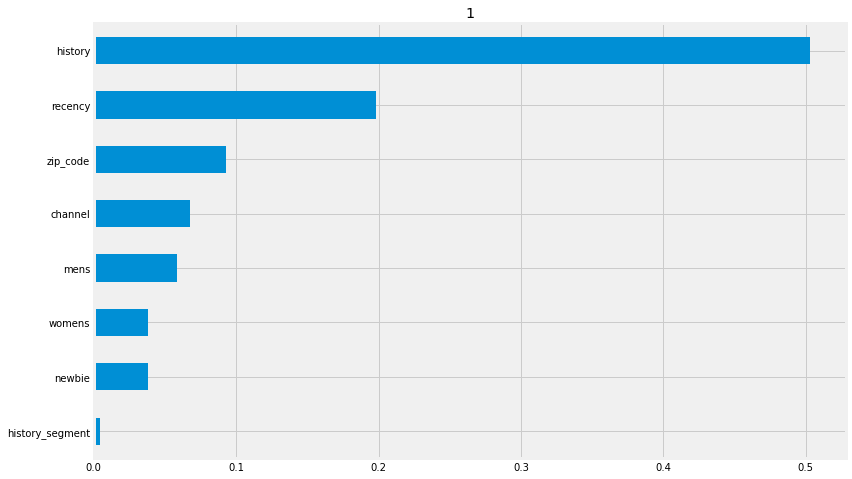

In [17]:
learner_s_xgbt.plot_importance(X=X, 
                         tau=slearner_tau_xgbt, 
                         normalize=True, 
                         method='auto', 
                         features=X.columns)


SHAP XGBT


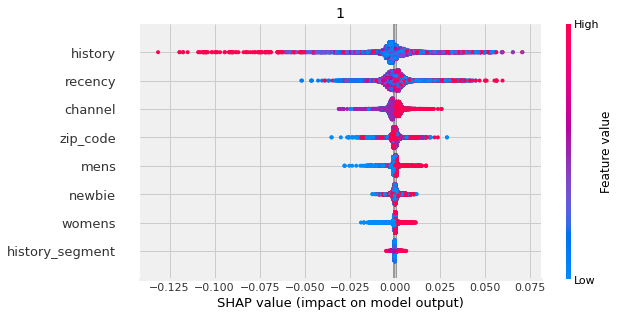

In [18]:
# Using SHAP
print("SHAP XGBT")
shap_slearner = learner_s_xgbt.get_shap_values(X=X, tau=slearner_tau_xgbt)
# Plot shap values without specifying shap_dict
learner_s_xgbt.plot_shap_values(X=X, shap_dict=shap_slearner, features=X.columns)

In [19]:
# Distribution fo ITE
slearner_tau_xgbt_reshaped = slearner_tau_xgbt.reshape(-1)

fig = go.Figure()
fig.add_trace(go.Histogram(x=slearner_tau_xgbt_reshaped, name = "xgbt"))

fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

# Distribution fo ITE(ranged)
slearner_tau_xgbt_reshaped_ranged = np.delete(
    slearner_tau_xgbt_reshaped,np.where((-0.1 > slearner_tau_xgbt_reshaped) | (slearner_tau_xgbt_reshaped > 0.1))
    )
fig = go.Figure()
fig.add_trace(go.Histogram(x=slearner_tau_xgbt_reshaped_ranged, name = "xgbt"))
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

# T-Learner

In [20]:
# True ATE
print("True ATE : ", True_ATE)

# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=T, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)
print('ATE estimate: {:.05f}'.format(ate_t[0][0]))
print('ATE lower bound: {:.05f}'.format(ate_t[1][0]))
print('ATE upper bound: {:.05f}'.format(ate_t[2][0]))

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=T, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)
print('ATE estimate: {:.05f}'.format(ate_t[0][0]))
print('ATE lower bound: {:.05f}'.format(ate_t[1][0]))
print('ATE upper bound: {:.05f}'.format(ate_t[2][0]))

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=T, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)
print('ATE estimate: {:.05f}'.format(ate_t[0][0]))
print('ATE lower bound: {:.05f}'.format(ate_t[1][0]))
print('ATE upper bound: {:.05f}'.format(ate_t[2][0]))

print("LightGBM")
learner_t_lgb = BaseTRegressor(learner=lgb.LGBMRegressor(), ate_alpha=0.05)
ate_t = learner_t_lgb.estimate_ate(X=X, treatment=T, y=y)
print(ate_t)
print("True ATE : ", True_ATE)
print('ATE estimate: {:.05f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.05f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.05f}'.format(ate_s[2][0]))

True ATE :  0.00681
Using the ready-to-use XGBTRegressor class
(array([0.00788286]), array([0.00644016]), array([0.00932556]))
ATE estimate: 0.00788
ATE lower bound: 0.00644
ATE upper bound: 0.00933

Using the BaseTRegressor class and using XGB (same result):
(array([0.00788286]), array([0.00644016]), array([0.00932556]))
ATE estimate: 0.00788
ATE lower bound: 0.00644
ATE upper bound: 0.00933

Using the BaseTRegressor class and using Linear Regression (different result):
(array([0.00770988]), array([0.00566948]), array([0.00975028]))
ATE estimate: 0.00771
ATE lower bound: 0.00567
ATE upper bound: 0.00975
LightGBM
(array([0.00785332]), array([0.00592147]), array([0.00978518]))
True ATE :  0.00681
ATE estimate: 0.00785
ATE lower bound: 0.00592
ATE upper bound: 0.00979


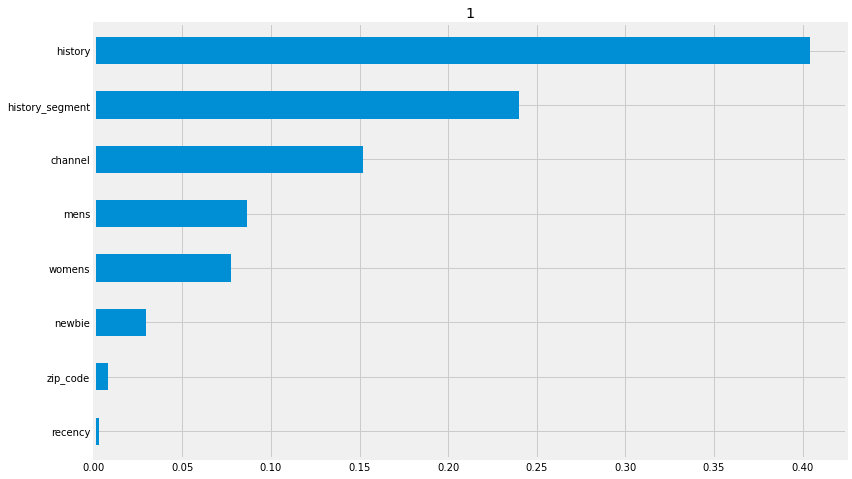

In [ ]:
tlearner_tau = learner_t.fit_predict(X, T, y)
learner_t.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=X.columns)

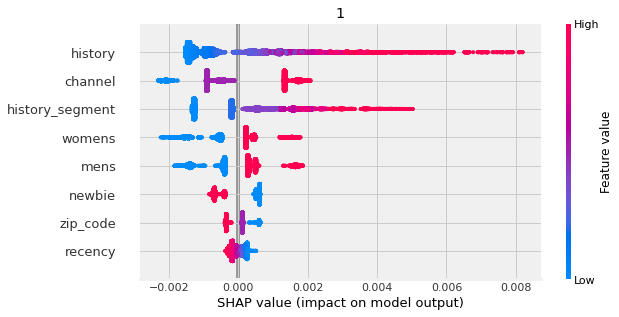

In [ ]:
# Using SHAP
shap_slearner = learner_t.get_shap_values(X=X, tau=tlearner_tau, features=X.columns)

# Plot shap values without specifying shap_dict
learner_t.plot_shap_values(X=X, shap_dict=shap_slearner, features=X.columns)

print("SHAP LightGBM")
shap_slearner = learner_s_lgb.get_shap_values(X=X, tau=slearner_tau_lgb)
# Plot shap values without specifying shap_dict
learner_s_lgb.plot_shap_values(X=X, shap_dict=shap_slearner, features=X.columns)

# X-Learner

In [ ]:
# True ATE
print("True ATE : ", True_ATE)

# X Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=T, y=y)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)
print('ATE estimate: {:.05f}'.format(ate_x[0][0]))
print('ATE lower bound: {:.05f}'.format(ate_x[1][0]))
print('ATE upper bound: {:.05f}'.format(ate_x[2][0]))

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=T, y=y)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)
print('ATE estimate: {:.05f}'.format(ate_x[0][0]))
print('ATE lower bound: {:.05f}'.format(ate_x[1][0]))
print('ATE upper bound: {:.05f}'.format(ate_x[2][0]))

True ATE :  0.00681
Using the BaseXRegressor class and using XGB:
(array([0.00796879]), array([0.00663038]), array([0.0093072]))
ATE estimate: 0.00797
ATE lower bound: 0.00663
ATE upper bound: 0.00931

Using the BaseXRegressor class and using Linear Regression:
(array([0.00770988]), array([0.00566948]), array([0.00975028]))
ATE estimate: 0.00771
ATE lower bound: 0.00567
ATE upper bound: 0.00975


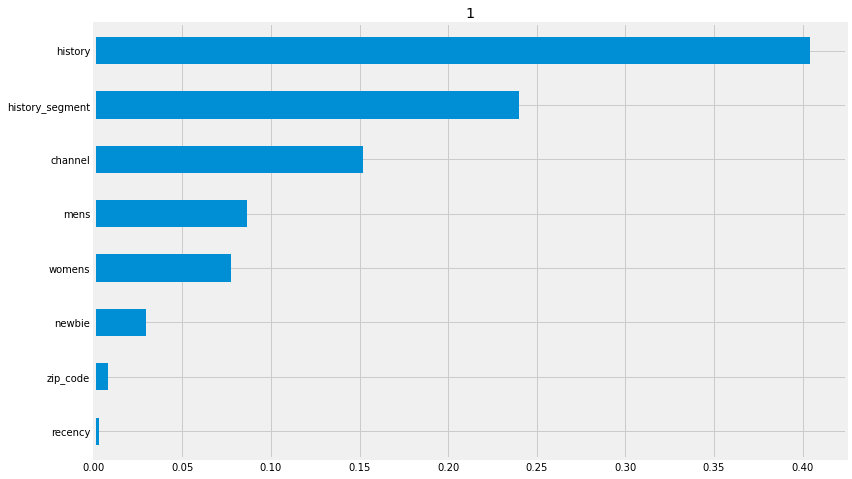

In [ ]:
xlearner_tau = learner_x.fit_predict(X, T, y)
learner_x.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=X.columns)

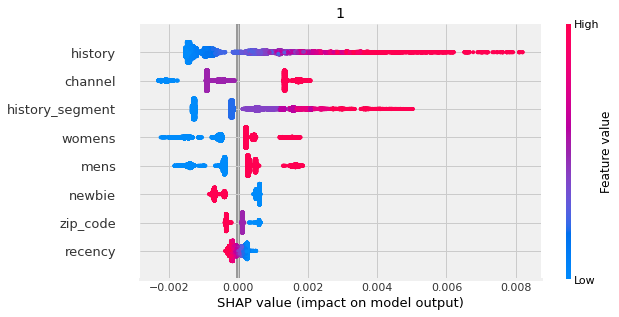

In [ ]:
# Using SHAP
shap_slearner = learner_x.get_shap_values(X=X, tau=xlearner_tau, features=X.columns)

# Plot shap values without specifying shap_dict
learner_x.plot_shap_values(X=X, shap_dict=shap_slearner, features=X.columns)

In [ ]:
# 個別効果があった人の数を見てみる
print("num_of_data : ", len(xlearner_tau))

cnt = 0
for i in xlearner_tau:
    if i > 0.01:
        cnt += 1

print("up more 1% : ", cnt)

cnt = 0
for i in xlearner_tau:
    if i > 0.005:
        cnt += 1

print("up more 0.5% : ", cnt)

cnt = 0
for i in xlearner_tau:
    if i > 0.001:
        cnt += 1

print("up more 0.1% : ", cnt)

num_of_data :  31925
up more 1% :  6752
up more 0.5% :  24446
up more 0.1% :  31925


# R-Learner

In [ ]:
# True ATE
print("True ATE : ", True_ATE)

# R Learner without propensity score input
# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=T, y=y)
print('Using the BaseRRegressor class and using Linear Regression without propensity score input:')
print(ate_r)
print('ATE estimate: {:.05f}'.format(ate_r[0][0]))
print('ATE lower bound: {:.05f}'.format(ate_r[1][0]))
print('ATE upper bound: {:.05f}'.format(ate_r[2][0]))

# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=T, y=y)
print('Using the BaseRRegressor class and using XGB without propensity score input:')
print(ate_r)
print('ATE estimate: {:.05f}'.format(ate_r[0][0]))
print('ATE lower bound: {:.05f}'.format(ate_r[1][0]))
print('ATE upper bound: {:.05f}'.format(ate_r[2][0]))


True ATE :  0.00681


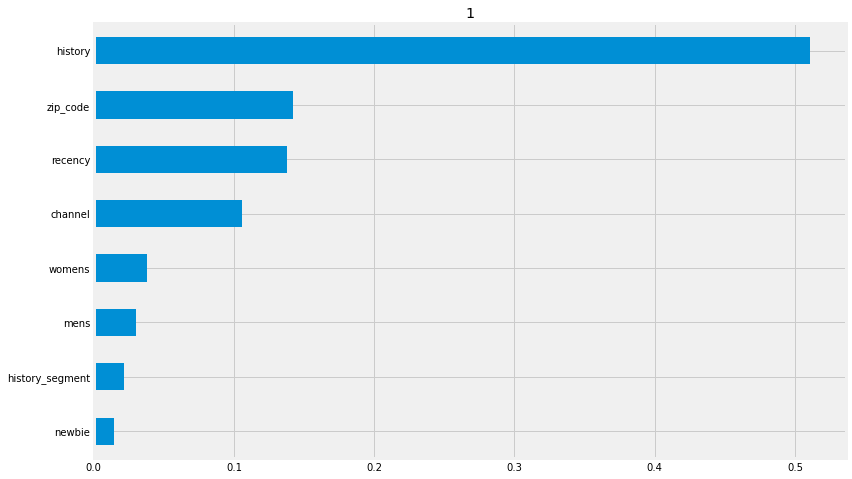

In [ ]:
rlearner_tau = learner_r.fit_predict(X, T, y)
learner_r.plot_importance(X=X, 
                         tau=rlearner_tau, 
                         normalize=True,
                         method='auto', 
                         features=X.columns)

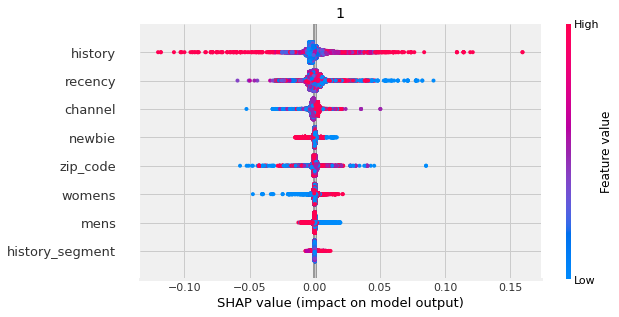

In [ ]:
# Using SHAP
shap_slearner = learner_r.get_shap_values(X=X, tau=rlearner_tau, features=X.columns)

# Plot shap values without specifying shap_dict
learner_r.plot_shap_values(X=X, shap_dict=shap_slearner, features=X.columns)

In [ ]:
# 個別効果があった人の数を見てみる（R-Learner）
print("num_of_data : ", len(rlearner_tau))

cnt = 0
for i in rlearner_tau:
    if i > 0.01:
        cnt += 1

print("up more 1% : ", cnt)

cnt = 0
for i in rlearner_tau:
    if i > 0.005:
        cnt += 1

print("up more 0.5% : ", cnt)

cnt = 0
for i in rlearner_tau:
    if i > 0.001:
        cnt += 1

print("up more 0.1% : ", cnt)

num_of_data :  31925
up more 1% :  10222
up more 0.5% :  18133
up more 0.1% :  24463
